In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [31]:

original_dataframe = pd.read_csv('24.csv')

In [32]:

def remove_outliers_iqr(df_orig):
  df = df_orig.copy()

  df_numeric = df.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_non_numeric = df.select_dtypes(exclude=['number'])

  Q1 = df_numeric.quantile(0.25)
  Q3 = df_numeric.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Removing outliers
  df_iqr = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]
  df_cleaned = pd.concat([df_iqr, df_non_numeric.loc[df_iqr.index]], axis=1)

  return df_cleaned

In [33]:
def remove_outliers_zscore(df_orig, z_score_threshold = 3):
  df = df_orig.copy()

  df_numeric = df.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_non_numeric = df.select_dtypes(exclude=['number'])

  z_scores = df_numeric.apply(zscore)
  df_z = df_numeric[(z_scores.abs() < z_score_threshold).all(axis=1)]  # Remove rows with Z-score >  z_score_threshold in any column
  df_cleaned = pd.concat([df_z, df_non_numeric.loc[df_z.index]], axis=1)

  return df_cleaned

In [34]:

def remove_highly_correlated(df_cleaned_orig, target_col="Hazardous", high_corr_threshold = 0.99):
  df_cleaned = df_cleaned_orig.copy()

  df_numeric = df_cleaned.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  target_series = None
  if target_col in df_numeric.columns: # High correaltion with target column should not be dropped
    target_series = df_cleaned[target_col]
    df_numeric = df_numeric.drop(columns=[target_col])

  high_corr_pairs = set()
  correlation_matrix = df_numeric.corr()

  for i in range(len(correlation_matrix.columns)):
    for j in range(i): # Lower triangular matrix
      if abs(correlation_matrix.iloc[i, j]) >= high_corr_threshold:
        col1 = correlation_matrix.columns[i]
        col2 = correlation_matrix.columns[j]
        high_corr_pairs.add((col1, col2))

  columns_to_drop = {col2 for col1, col2 in high_corr_pairs}
  df_reduced = df_cleaned.drop(columns=columns_to_drop)

  if target_series is not None: # If present in df_numeric and is removed, has to be added again
    df_reduced[target_col] = target_series

  return df_reduced

In [35]:

def normalize_minmax(df_train, df_test, df_valid):
  scaler = MinMaxScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_test, df_valid

In [36]:

def standardize_data(df_train, df_test, df_valid):
  scaler = StandardScaler()

  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_test_numeric = df_test.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])
  df_valid_numeric = df_valid.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  df_train[df_train_numeric.columns] = scaler.fit_transform(df_train_numeric)
  df_test[df_test_numeric.columns] = scaler.transform(df_test_numeric)
  df_valid[df_valid_numeric.columns] = scaler.transform(df_valid_numeric)

  return df_train, df_test, df_valid

In [37]:

def label_encode_categorical(df_normalized):
  df_normalized_copy = df_normalized.copy()

  categorical_cols = df_normalized_copy.select_dtypes(include=['object']).columns
  label_encoder = LabelEncoder()

  for col in categorical_cols:
    df_normalized_copy[col] = label_encoder.fit_transform(df_normalized_copy[col])

  return df_normalized_copy

In [38]:

def select_high_corr_features(df_train, df_test, df_valid, target_col="Hazardous", top_n=3):
  df_train_numeric = df_train.select_dtypes(include=['number']).select_dtypes(exclude=['bool'])

  # If target column is not in numerical form
  if target_col not in df_train_numeric.columns:
      raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataset.")

  corr_values = df_train_numeric.corr()[target_col].abs().sort_values(ascending=False)
  selected_features = corr_values.drop(index=target_col).head(top_n).index.tolist()

  # print(f"Selected features based on correlation with '{target_col}': {selected_features}")

  return df_train[selected_features], df_test[selected_features], df_valid[selected_features]

In [39]:

def perform_pca(df_train, df_test, df_valid, n_components):
  pca = PCA(n_components=n_components)

  df_train_numeric = df_train.select_dtypes(include=['number'])
  df_test_numeric = df_test.select_dtypes(include=['number'])
  df_valid_numeric = df_valid.select_dtypes(include=['number'])

  pca.fit(df_train_numeric)
  df_train_pca = pca.transform(df_train_numeric)
  df_test_pca = pca.transform(df_test_numeric)
  df_valid_pca = pca.transform(df_valid_numeric)

  pca_columns = [f'PC{i+1}' for i in range(n_components)]
  df_train_pca = pd.DataFrame(df_train_pca, columns=pca_columns)
  df_test_pca = pd.DataFrame(df_test_pca, columns=pca_columns)
  df_valid_pca = pd.DataFrame(df_valid_pca, columns=pca_columns)

  return df_train_pca, df_test_pca, df_valid_pca

In [40]:
def numeric_conversion(df_orig, one_hot_encode_month=False):
  df = df_orig.copy()

  # Dropping 'Equinox' and 'Orbiting Body'
  df.drop(columns=['Equinox', 'Orbiting Body'], errors='ignore', inplace=True)

  # Converting 'Close Approach Date' to datetime
  df['Close Approach Date'] = pd.to_datetime(df['Close Approach Date'])
  df['Close Approach Year'] = df['Close Approach Date'].dt.year
  df['Close Approach Month'] = df['Close Approach Date'].dt.month



  # Converting 'Epoch Date Close Approach' to datetime
  df['Converted Date'] = df['Epoch Date Close Approach'].apply(
    lambda x: datetime.utcfromtimestamp(x / 1000) if pd.notnull(x) else None
  )

  df['Epoch Close Approach Year'] = df['Converted Date'].dt.year
  df['Epoch Close Approach Month'] = df['Converted Date'].dt.month



  # Encoding 'Hazardous' column
  df['Hazardous'] = df['Hazardous'].astype(int)

  # One-Hot Encoding for months (if needed)
  if one_hot_encode_month:
    df = pd.get_dummies(df, columns=['Close Approach Month', 'Epoch Close Approach Month'], prefix=['Close Approach Month no.', 'Epoch Close Approach Month no.'], dtype=int)

  df = df.drop(columns=["Converted Date"])
  return df

In [41]:

def data_preprocessing(df):
  no_outliers = remove_outliers_zscore(df)
  no_highly_correlated = remove_highly_correlated(no_outliers)
  encoded = numeric_conversion(no_highly_correlated)
  df_train, df_temp = train_test_split(encoded, test_size=0.4, random_state=42)
  df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
  normal_train, normal_test, normal_valid = normalize_minmax(df_train, df_test, df_valid)
  normal_train.reset_index(drop=True, inplace=True)
  normal_valid.reset_index(drop=True, inplace=True)
  normal_test.reset_index(drop=True, inplace=True)
  return normal_train, normal_valid, normal_test

In [42]:
normal_train, normal_valid, normal_test = data_preprocessing(original_dataframe)

C:\Users\lohit\AppData\Local\Temp\ipykernel_64816\3347725585.py:16: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  lambda x: datetime.utcfromtimestamp(x / 1000) if pd.notnull(x) else None


In [43]:
target_column = "Hazardous"


In [44]:

X_train = normal_train.drop(columns=[target_column])
y_train = normal_train[target_column]

In [45]:

X_valid = normal_valid.drop(columns=[target_column])
y_valid = normal_valid[target_column]

In [46]:
X_test = normal_test.drop(columns=[target_column])
y_test = normal_test[target_column]

In [47]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)
     

X_train shape: (2512, 26)
X_valid shape: (837, 26)
X_test shape: (838, 26)


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

In [49]:

X_train["Close Approach Date"] = X_train["Close Approach Date"].astype("int64") // 10**9  # Convert to seconds
X_valid["Close Approach Date"] = X_valid["Close Approach Date"].astype("int64") // 10**9
X_test["Close Approach Date"] = X_test["Close Approach Date"].astype("int64") // 10**9

In [50]:

X_train["Orbit Determination Date"] = pd.to_datetime(X_train["Orbit Determination Date"]).astype("int64") // 10**9
X_valid["Orbit Determination Date"] = pd.to_datetime(X_valid["Orbit Determination Date"]).astype("int64") // 10**9
X_test["Orbit Determination Date"] = pd.to_datetime(X_test["Orbit Determination Date"]).astype("int64") // 10**9

In [51]:
X_train, y_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32), torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1,1)
X_valid, y_valid = torch.tensor(X_valid.to_numpy(), dtype=torch.float32), torch.tensor(y_valid.to_numpy(), dtype=torch.float32).view(-1,1)
X_test, y_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32), torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1,1)

In [52]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(NeuralNet, self).__init__()
        layers = []
        prev_size = input_size
        for layer_size in hidden_layers:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.Sigmoid())
            prev_size = layer_size
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def evaluate_model(X, y):
    y_pred = model(X).detach().numpy()
    y_pred = (y_pred > 0.5).astype(int)
    y_true = y.numpy()
    
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred,zero_division = np.nan))
    print("Recall:", recall_score(y_true, y_pred,zero_division = np.nan))
    print("F1 Score:", f1_score(y_true, y_pred,zero_division = np.nan))

Layer: 10,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 17,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 31,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 64,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8

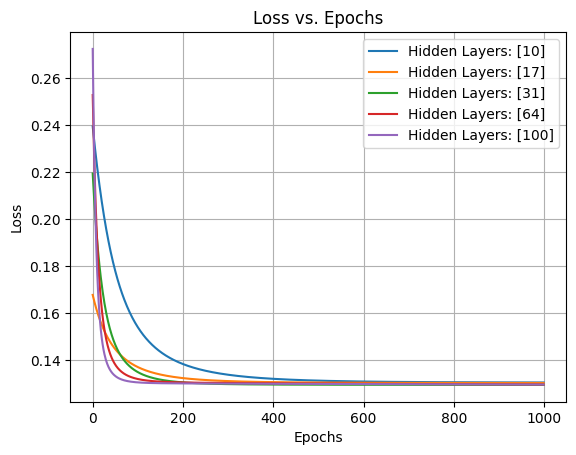

In [53]:
hidden_layers_list = [[10],[17],[31],[64],[100]]
for layer in hidden_layers_list:
    model = NeuralNet(input_size=26, hidden_layers=layer)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    epochs = 1000
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients to zero before each forward pass
    
        outputs = model(X_train)  # Forward pass: Compute predictions
        loss = criterion(outputs, y_train)  # Compute loss
    
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model weights
        loss_history.append(loss.item())
    print("Layer: ",end="")
    for i in layer:
        print(i,end=",")
    print()
    #for epoch in range(epochs):
     #    for i in range(len(X_train)):  # Loop through each training sample
      #       optimizer.zero_grad()
       #
        #     output = model(X_train[i].unsqueeze(0))  # Forward pass for one sample
         #    loss = criterion(output, y_train[i].unsqueeze(0))  # Compute loss for one sample
       #
        #     loss.backward()  # Compute gradients for this sample
         #    optimizer.step()  # Update weights after each sample
        #
         #    loss_history.append(loss.item())
    print("Training complete!")
    plt.plot(range(epochs), loss_history, label=f"Hidden Layers: {layer}")
    print("Validation Performance:")
    evaluate_model(X_valid, y_valid)
    print("Test Performance:")
    evaluate_model(X_test, y_test)
    print()
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.grid(True)
plt.legend()
plt.show()
    



Layer: 64,16,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 128,32,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 256,64,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0]]
Accuracy: 0.8148148148148148
Precision: nan
Recall: 0.0
F1 Score: 0.0
Test Performance:
Confusion Matrix:
 [[722   0]
 [116   0]]
Accuracy: 0.8615751789976134
Precision: nan
Recall: 0.0
F1 Score: 0.0

Layer: 512,128,
Training complete!
Validation Performance:
Confusion Matrix:
 [[682   0]
 [155   0

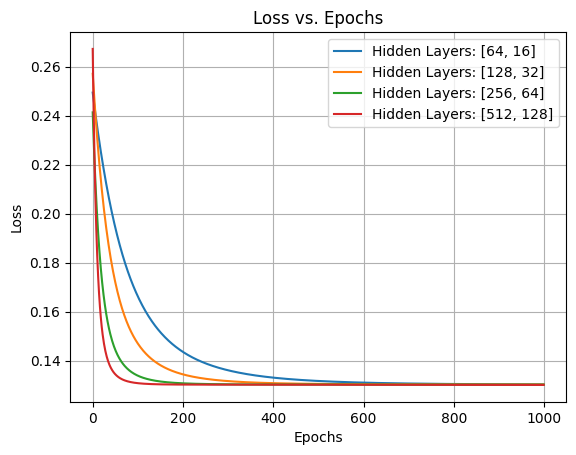

In [54]:
hidden_layers_list = [[64,16],[128,32],[256,64],[512,128]]
for layer in hidden_layers_list:
    model = NeuralNet(input_size=26, hidden_layers=layer)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    epochs = 1000
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients to zero before each forward pass
    
        outputs = model(X_train)  # Forward pass: Compute predictions
        loss = criterion(outputs, y_train)  # Compute loss
    
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model weights
        loss_history.append(loss.item())
    print("Layer: ",end="")
    for i in layer:
        print(i,end=",")
    print()
    #for epoch in range(epochs):
     #    for i in range(len(X_train)):  # Loop through each training sample
      #       optimizer.zero_grad()
       #
        #     output = model(X_train[i].unsqueeze(0))  # Forward pass for one sample
         #    loss = criterion(output, y_train[i].unsqueeze(0))  # Compute loss for one sample
       #
        #     loss.backward()  # Compute gradients for this sample
         #    optimizer.step()  # Update weights after each sample
        #
         #    loss_history.append(loss.item())
    print("Training complete!")
    plt.plot(range(epochs), loss_history, label=f"Hidden Layers: {layer}")
    print("Validation Performance:")
    evaluate_model(X_valid, y_valid)
    print("Test Performance:")
    evaluate_model(X_test, y_test)
    print()
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.grid(True)
plt.legend()
plt.show()
    

